In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.core.display import HTML
from sklearn.tree import export_text
# from operator import itemgetter
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from IPython.display import Image
import graphviz
import pydotplus
from io import StringIO
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from mlxtend.classifier import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from gmdhpy import gmdh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    x1=10
    x2=0
    
    _X = np.concatenate((df.iloc[:, df.columns ==df.columns[x1]].values, df.iloc[:, df.columns ==df.columns[x2]].values), axis=1)
    _y = df.iloc[:, df.columns == 'quality'].values
    
    clf.fit(_X, _y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = _X[:, 0], _X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(df.columns[x1])
    ax.set_ylabel(df.columns[x2])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [4]:
df = pd.read_csv('./content/winequality.csv')
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  good                  6497 non-null   int64  
 13  color                 6497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


In [6]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
good                    0
color                   0
dtype: int64

In [7]:
le = LabelEncoder()
df['color']= le.fit_transform(df['color'])

# разделение на объекты-признаки и целевой признак
X = pd.DataFrame(df.iloc[:, df.columns != 'quality'].values, columns=[column for column in df.columns if column!='quality'])
y = pd.DataFrame(df.iloc[:, df.columns == 'quality'].values, columns=['quality'])


In [8]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0.0,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0.0,1.0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0.0,1.0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0.0,1.0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1.0,1.0


In [9]:
y

,quality
0,5
1,5
2,5
3,6
4,5
...,...
6492,6
6493,5
6494,6
6495,7


In [10]:
# Формирование обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [11]:
# Случайный лес
r_forest = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=10)
r_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, oob_score=True, random_state=10)

In [12]:
tree = export_text(r_forest[0], feature_names=list(X_train.columns))
HTML('<pre>' + tree + '</pre>')

In [13]:
# Out-of-bag error, возвращаемый классификатором
r_forest.oob_score_, r_forest.oob_score_

(0.7629401577833366, 0.7629401577833366)

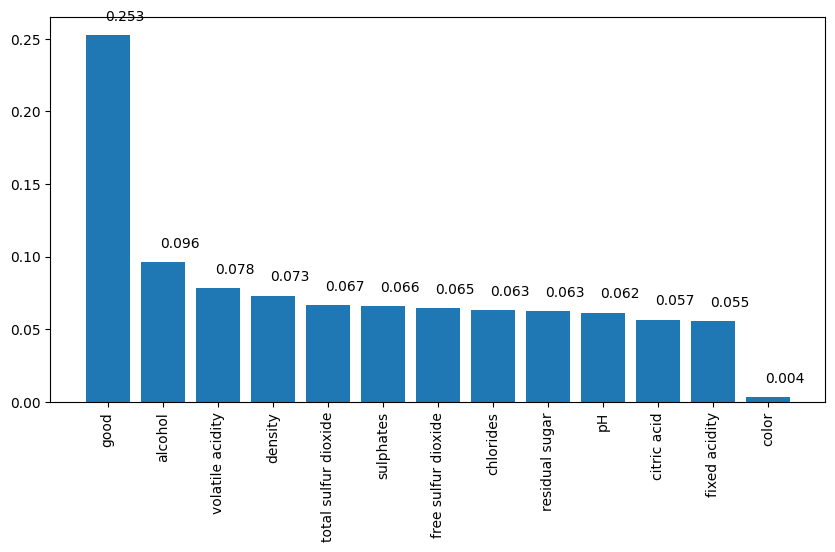

In [14]:
_,_ = draw_feature_importances(r_forest, X_train)

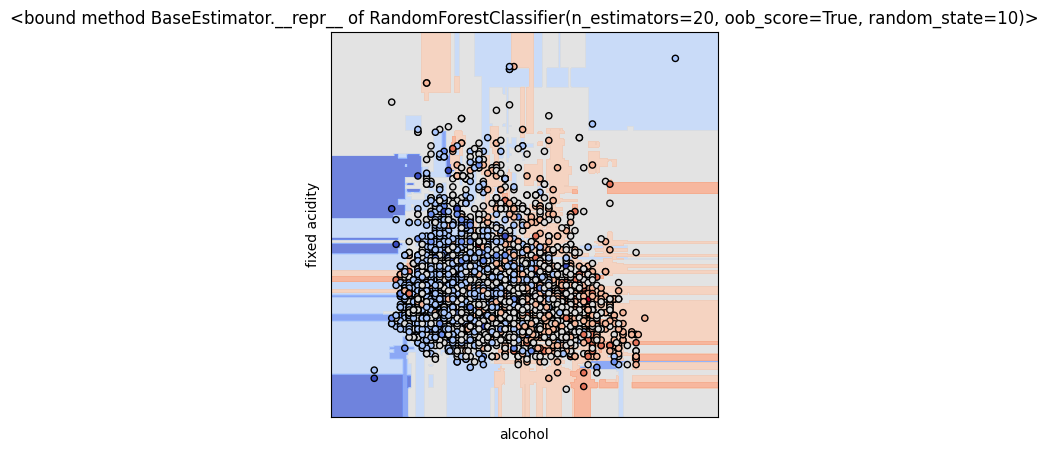

In [15]:
plot_cl(r_forest)

In [16]:
# Бэггинг
BagModel = BaggingClassifier(n_estimators=20, oob_score=True, random_state=10)

In [17]:
BagModel.fit(X_train, y_train)

BaggingClassifier(n_estimators=20, oob_score=True, random_state=10)

In [18]:
y_bag_predict = BagModel.predict(X_test)

In [19]:
y_bag_predict

array([5, 5, 5, ..., 5, 5, 7], dtype=int64)

In [20]:
accuracy_score(y_test, y_bag_predict)

0.7538461538461538

In [21]:
BagModel.oob_score_, 1-BagModel.oob_score_

(0.7512026168943622, 0.24879738310563781)

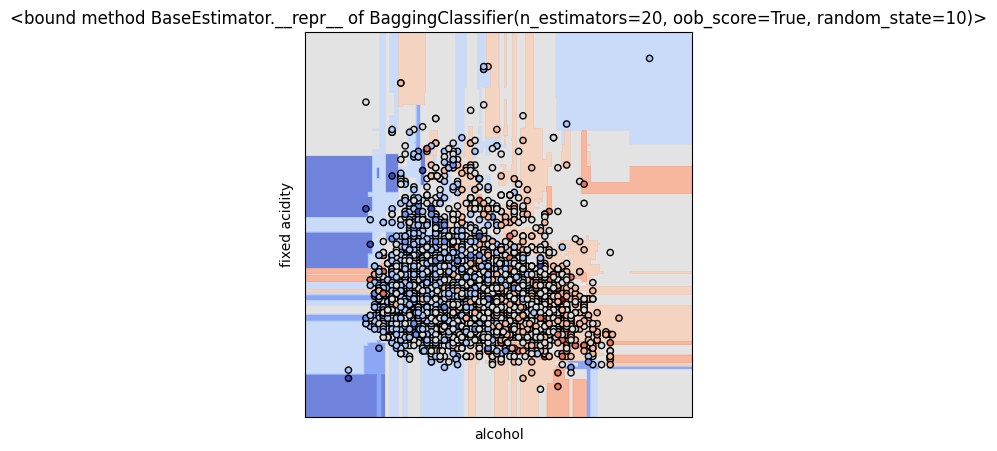

In [22]:
plot_cl(BagModel)

In [23]:
# Бустинг
GradBoost = GradientBoostingClassifier(n_estimators=5, random_state=10)
GradBoost.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=5, random_state=10)

In [24]:
y_boosting_predict = GradBoost.predict(X_test)

In [25]:
accuracy_score(y_test, y_boosting_predict)

0.6861538461538461

In [26]:
recall_score(y_test, y_boosting_predict, average=None)

array([0.25      , 0.        , 0.55862069, 0.7712305 , 0.99014778,
       0.0625    , 0.        ])

In [27]:
precision_score(y_test, y_boosting_predict, average=None)

array([0.2       , 0.        , 0.61832061, 0.67629179, 0.86637931,
       0.66666667, 0.        ])

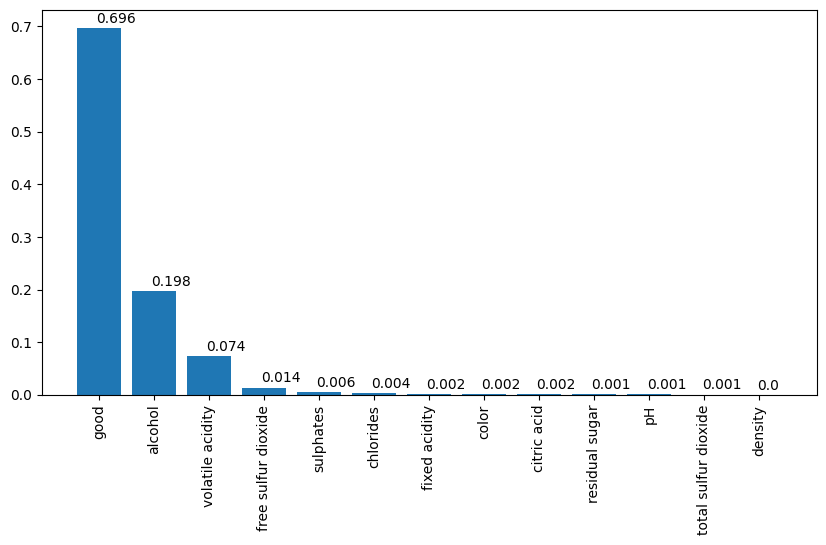

In [28]:
_,_ = draw_feature_importances(GradBoost, X_train)

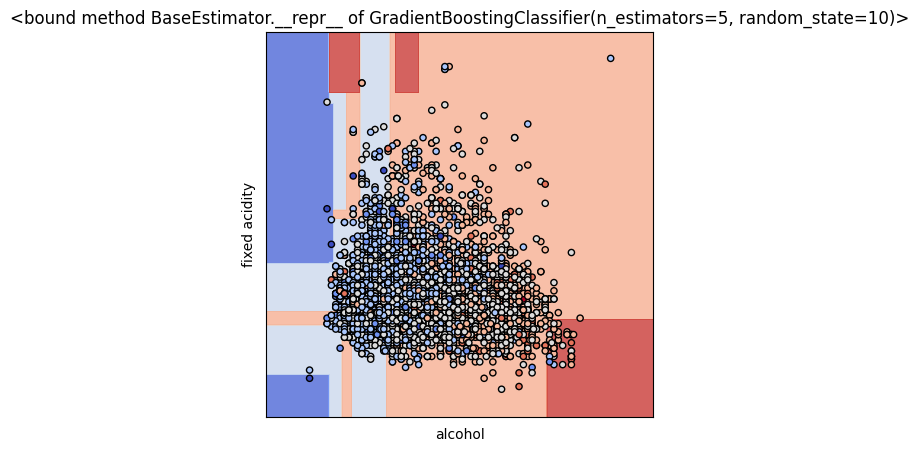

In [29]:
plot_cl(GradBoost)

In [30]:
# Стэкинг
# Эксперимент 1
# Первый уровень - две модели: дерево и логистическая регрессия
# Второй уровень: логистическая регрессия
clf1 = DecisionTreeClassifier(random_state=1)
clf2 = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier = clf2)

In [31]:
for clf, label in zip([clf1, clf2, sclf], ['Tree', 'Logistic', 'Stacking']):
    clf.fit(X_train, y_train)
    y_stack_predict = clf.predict(X_test)
    print("Accuracy score: %0.2f [%s]" % (accuracy_score(y_test, y_stack_predict), label))

Accuracy score: 0.70 [Tree]
Accuracy score: 0.60 [Logistic]
Accuracy score: 0.72 [Stacking]


In [32]:
# Эксперимент 2
# Первый уровень - две модели: дерево и логистическая регрессия
# Второй уровень: случайный лес
clf1 = DecisionTreeClassifier(random_state=1)
clf2 = LogisticRegression()
clf3 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier = clf3)

In [33]:
for clf, label in zip([clf1, clf2, sclf], ['Tree', 'Logistic', 'Stacking']):
    clf.fit(X_train, y_train)
    y_stack_predict = clf.predict(X_test)
    print("Accuracy score: %0.2f [%s]" % (accuracy_score(y_test, y_stack_predict), label))

Accuracy score: 0.70 [Tree]
Accuracy score: 0.60 [Logistic]
Accuracy score: 0.70 [Stacking]


In [34]:
# Эксперимент 3
# Первый уровень - две модели: логистическая регрессия и случайный лес
# Второй уровень: случайный лес
# clf1 = DecisionTreeClassifier(random_state=1)
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=13)
sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier = clf2)

In [35]:
for clf, label in zip([clf1, clf2, sclf], ['Logistic', 'Forest', 'Stacking']):
    clf.fit(X_train, y_train)
    y_stack_predict = clf.predict(X_test)
    print("Accuracy score: %0.2f [%s]" % (accuracy_score(y_test, y_stack_predict), label))


Accuracy score: 0.60 [Logistic]
Accuracy score: 0.72 [Forest]
Accuracy score: 0.72 [Stacking]


In [36]:
# ДОПКА
# многослойный перцептрон
n_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [37]:
n_clf.predict_proba(X_test[:1])

array([[2.81916240e-03, 3.28446171e-02, 3.15169324e-01, 6.46399608e-01,
        1.30875484e-03, 1.28356844e-03, 1.74964489e-04]])

In [38]:
y_neuro_predict = n_clf.predict(X_test)
y_neuro_predict

array([6, 6, 6, ..., 5, 5, 7], dtype=int64)

In [39]:
n_clf.score(X_test, y_test)

0.6630769230769231

In [40]:
accuracy_score(y_test, y_neuro_predict)

0.6630769230769231

In [41]:
# Метод группового учета аргументов
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [52]:
model = gmdh.Regressor()

In [53]:
model.fit(X_train.to_numpy(), y_train.to_numpy(), validation_data=(X_test.to_numpy(), y_test.to_numpy()))

train layer0 in 0.22 sec
train layer1 in 0.94 sec
train layer2 in 0.90 sec
train layer3 in 0.86 sec
train layer4 in 0.87 sec
train layer5 in 0.88 sec
train layer6 in 0.85 sec
train layer7 in 0.95 sec
train layer8 in 0.90 sec


In [57]:
predict_y = model.predict(X_test.to_numpy())
result = mean_absolute_error(y_test.to_numpy(), predict_y)
print(model)
print('MAE={}'.format(result))

Self-organizing deep learning polynomial neural network
MAE=0.4238032890747085


In [60]:
bin_y = convert_target_to_binary(df['quality'], 6)

In [64]:
df_gmdh = df
df_gmdh['quality_bin'] = bin_y
df_gmdh.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,quality_bin
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,0,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0,0


In [65]:
gmdh_X_train, gmdh_X_test, gmdh_y_train, gmdh_y_test = train_test_split(
    X, 
    df_gmdh['quality_bin'].values, test_size=0.1, random_state=1)

In [69]:
model = gmdh.Classifier()
model.fit(gmdh_X_train.to_numpy(), gmdh_y_train, validation_data=(gmdh_X_test.to_numpy(), gmdh_y_test))

train layer0 in 1.12 sec
train layer1 in 6.85 sec
train layer2 in 5.85 sec
train layer3 in 6.44 sec
train layer4 in 6.64 sec
train layer5 in 6.08 sec
train layer6 in 6.15 sec
train layer7 in 6.05 sec
train layer8 in 6.47 sec


In [72]:
predicted_scores = model.predict_proba(gmdh_X_test.to_numpy())
predicted_scores

array([3.29985894e-01, 5.09349992e-01, 4.30396097e-01, 6.45009548e-01,
       2.58257053e-01, 3.99389895e-04, 7.16689187e-01, 6.71400890e-01,
       6.34416759e-01, 3.57137817e-01, 5.95995673e-01, 7.74586126e-01,
       4.39524605e-01, 3.97802664e-04, 3.97243836e-04, 7.13967225e-01,
       2.84454261e-01, 3.13271413e-01, 6.62946986e-01, 4.00762232e-04,
       3.99531813e-04, 4.11054495e-01, 5.15790153e-01, 5.91074260e-01,
       3.99748290e-04, 3.89950376e-04, 4.98416023e-01, 3.71650922e-01,
       7.30751607e-01, 6.65925650e-01, 4.30725924e-01, 3.38788847e-01,
       6.03580797e-01, 3.79109643e-01, 2.22297164e-01, 1.97702069e-01,
       6.22473679e-01, 3.94796502e-04, 3.99378549e-04, 8.42052857e-01,
       3.99070520e-04, 4.99771196e-01, 4.00850566e-04, 6.58073791e-01,
       8.47126300e-01, 3.97842514e-04, 3.51978263e-01, 4.71294117e-01,
       2.97266888e-01, 4.00764743e-04, 3.79491932e-01, 4.96387878e-01,
       4.24740921e-01, 2.13151223e-01, 4.61204688e-01, 7.96432954e-01,
      

In [73]:
for i in range(len(predicted_scores)):
    if predicted_scores[i] >= 0.5:
        predicted_scores[i] = 1
    else:
        predicted_scores[i] = 0
predicted_scores

array([0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 0.

In [74]:
accuracy_score(gmdh_y_test, predicted_scores)

0.7292307692307692

In [75]:
recall_score(gmdh_y_test, predicted_scores)

0.6556291390728477

In [76]:
precision_score(gmdh_y_test, predicted_scores)

0.7333333333333333